In [1]:
# SPY 数据集
import yfinance as yf
import pandas as pd

# === 定义抓取时间段 ===
periods = {
    "term1": ("2017-01-20", "2021-01-08"),
    "term2": ("2025-01-20", "2025-07-20")
}

# === 抓取数据 ===
all_data = []

for name, (start_date, end_date) in periods.items():
    spy = yf.download("SPY", start=start_date, end=end_date, interval="1d")
    spy.reset_index(inplace=True)
    spy = spy[["Date", "Close"]]
    spy.columns = ["date", "price"]
    spy["term"] = name
    spy.to_csv(f"spy_{name}.csv", index=False)  # 保存各自数据
    all_data.append(spy)

# === 合并保存所有数据（可选）===
merged = pd.concat(all_data).reset_index(drop=True)
merged.to_csv("spy_merged.csv", index=False)

print("✅ 数据抓取完毕：spy_term1.csv, spy_term2.csv, spy_merged.csv 已保存")


/var/folders/kl/y_1kmntx0dl9d7tfqpwvvxch0000gn/T/ipykernel_14460/3593568207.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("SPY", start=start_date, end=end_date, interval="1d")
[*********************100%***********************]  1 of 1 completed
/var/folders/kl/y_1kmntx0dl9d7tfqpwvvxch0000gn/T/ipykernel_14460/3593568207.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("SPY", start=start_date, end=end_date, interval="1d")
[*********************100%***********************]  1 of 1 completed

✅ 数据抓取完毕：spy_term1.csv, spy_term2.csv, spy_merged.csv 已保存


In [4]:
import pandas as pd

# === 1. 读取数据 ===
# 日度情绪比例数据
sentiment_df = pd.read_csv("/Users/wangyijie/Visual_Studio_code/毕业论文项目/02情感分析/daily_sentiment_ratios.csv")

# SPY 市场价格数据（需包含 date 和 price 列）
price_df = pd.read_csv("/Users/wangyijie/Visual_Studio_code/毕业论文项目/03金融市场分析与建模/spy_merged.csv")

# === 2. 处理日期字段 ===
sentiment_df["day"] = pd.to_datetime(sentiment_df["day"])
price_df["date"] = pd.to_datetime(price_df["date"])

# === 3. 按日期排序 ===
price_df = price_df.sort_values("date").reset_index(drop=True)

# === 4. 计算每日收益率 ===
price_df["return"] = price_df["price"].pct_change()

# === 5. 构建前一日收益率特征 ===
price_df["prev_return"] = price_df["return"].shift(1)

# === 6. 构建 rolling_std（过去5日收益率标准差） ===
price_df["rolling_std"] = price_df["return"].rolling(window=5).std()

# === 7. 合并情绪与价格特征 ===
merged_df = pd.merge(
    sentiment_df,
    price_df[["date", "price", "prev_return", "rolling_std"]],
    left_on="day",
    right_on="date",
    how="inner"
)

# 删除包含任何 NaN 的行
merged_df = merged_df.dropna().reset_index(drop=True)
# === 8. 保存结果 ===
merged_df.to_csv("sentiment_SPY_features.csv", index=False)

print("✅ 已生成 sentiment_SPY_features.csv，包含 prev_return 和 rolling_std")


✅ 已生成 sentiment_SPY_features.csv，包含 prev_return 和 rolling_std


🔍 Baseline Model Evaluation:
[[139  14]
 [ 43  27]]
              precision    recall  f1-score   support

           0       0.76      0.91      0.83       153
           1       0.66      0.39      0.49        70

    accuracy                           0.74       223
   macro avg       0.71      0.65      0.66       223
weighted avg       0.73      0.74      0.72       223

ROC AUC: 0.7441643323996265


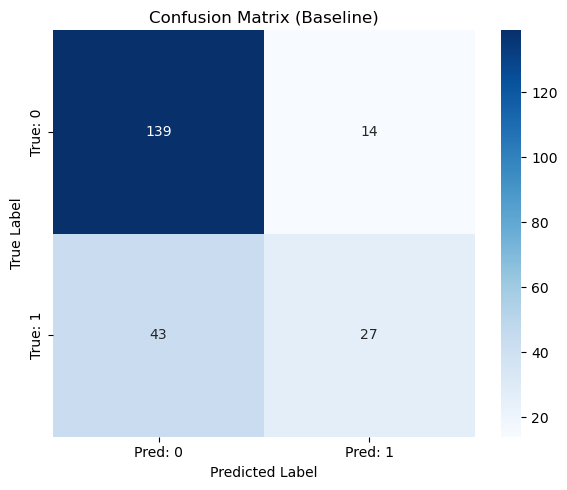

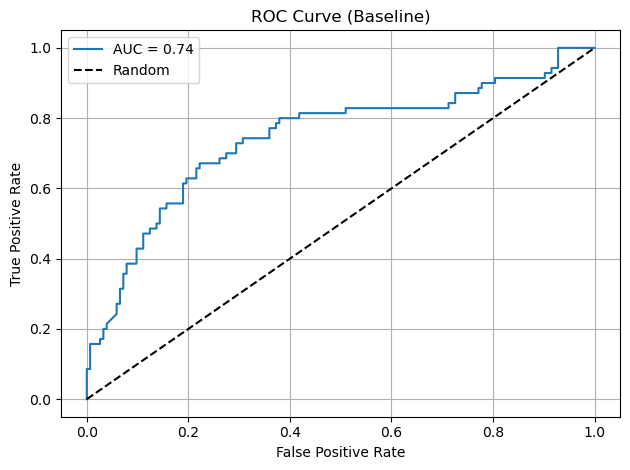

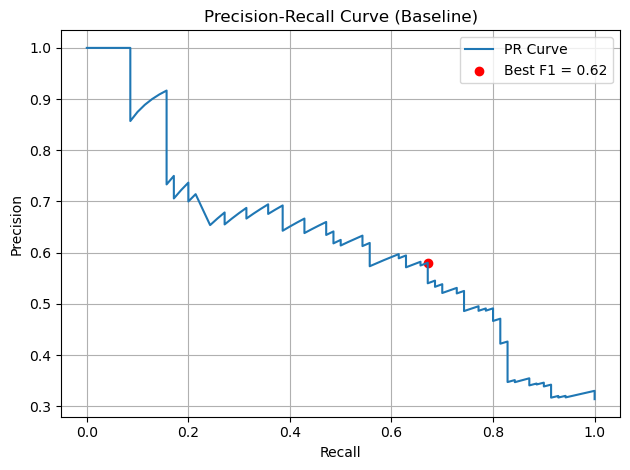

In [19]:
# 基线模型,不加入情绪特征
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix,
                             roc_curve, precision_recall_curve)

# 加载数据
df = pd.read_csv("/Users/wangyijie/Visual_Studio_code/毕业论文项目/03金融市场分析与建模/sentiment_SPY_features.csv")
df = df.dropna().reset_index(drop=True)

# 标签变量
df["return"] = df["price"].pct_change()
df["high_volatility"] = (df["return"].abs() > 0.01).astype(int)
y = df["high_volatility"]

# 👉 只使用价格类特征
X = df[["prev_return", "rolling_std"]]

# 时间顺序划分训练集和测试集
split_index = int(len(df) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 模型训练（默认参数）
svm_baseline = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
svm_baseline.fit(X_train_scaled, y_train)

# 模型预测
y_pred = svm_baseline.predict(X_test_scaled)
y_scores = svm_baseline.decision_function(X_test_scaled)

# 评估
print("🔍 Baseline Model Evaluation:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_scores))

#  混淆矩阵热图
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Pred: 0', 'Pred: 1'],
            yticklabels=['True: 0', 'True: 1'])
plt.title("Confusion Matrix (Baseline)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("baseline_confusion_matrix.png", dpi=300)
plt.show()

#  ROC 曲线
fpr, tpr, _ = roc_curve(y_test, y_scores)
auc_score = roc_auc_score(y_test, y_scores)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Baseline)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("baseline_roc_curve.png", dpi=300)
plt.show()

#  PR 曲线 + 最优 F1
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
f1 = 2 * precision * recall / (precision + recall + 1e-8)
best_idx = np.argmax(f1)

plt.figure()
plt.plot(recall, precision, label='PR Curve')
plt.scatter(recall[best_idx], precision[best_idx], color='red', label=f'Best F1 = {f1[best_idx]:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Baseline)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("baseline_pr_curve.png", dpi=300)
plt.show()

In [6]:
# SVM 波动率预测
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# === 1. 读取数据 ===
df = pd.read_csv("/Users/wangyijie/Visual_Studio_code/毕业论文项目/03金融市场分析与建模/sentiment_SPY_features.csv")
df["date"] = pd.to_datetime(df["date"])

# === 2. 清洗缺失值 ===
df = df.dropna().reset_index(drop=True)

# === 3. 构建标签变量：是否大幅波动（绝对涨跌幅 > 1%）===
df["return"] = df["price"].pct_change()
df["high_volatility"] = (df["return"].abs() > 0.01).astype(int)

# === 4. 特征选择 ===
features = ["positive_ratio", "negative_ratio", "neutral_ratio", "total", "prev_return", "rolling_std"]
X = df[features]
y = df["high_volatility"]

# === 5. 特征标准化 ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 6. 时间顺序划分训练/测试集 ===
split_index = int(len(df) * 0.8)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# === 7. 构建并训练 SVM 模型 ===
model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
model.fit(X_train, y_train)

# === 8. 模型预测与评估 ===
y_pred = model.predict(X_test)
y_score = model.decision_function(X_test)

# 输出结果
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_score))


Confusion Matrix:
[[148   5]
 [ 57  13]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.97      0.83       153
           1       0.72      0.19      0.30        70

    accuracy                           0.72       223
   macro avg       0.72      0.58      0.56       223
weighted avg       0.72      0.72      0.66       223

ROC AUC Score: 0.7416433239962652


In [4]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

param_grid = {
    'C': [0.01, 0.1, 0.5, 1, 2, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

cv = TimeSeriesSplit(n_splits=5)

svc = SVC(probability=True)
grid = GridSearchCV(svc, param_grid, scoring='roc_auc', cv=cv)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

print("Best AUC score:", grid.best_score_)


Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best AUC score: 0.8562060410611313


In [5]:
from sklearn.metrics import precision_recall_curve
model = grid.best_estimator_
# 使用预测得分（决策函数）计算 precision-recall 曲线
probs = model.decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# 找到 recall > 0.5 且 F1 最优的阈值
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print("最佳阈值:", best_threshold)
print("对应的 Recall:", recall[best_idx])
print("对应的 F1 Score:", f1_scores[best_idx])

# 应用最佳阈值重新分类
y_pred_custom = (probs >= best_threshold).astype(int)


最佳阈值: -0.9759101405594093
对应的 Recall: 0.8285714285714286
对应的 F1 Score: 0.6338797766968259


In [8]:
# 应用新阈值
y_pred_custom = (model.decision_function(X_test) >= -0.932).astype(int)

# 重新评估
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred_custom))
print(classification_report(y_test, y_pred_custom))


[[133  20]
 [ 30  40]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       153
           1       0.67      0.57      0.62        70

    accuracy                           0.78       223
   macro avg       0.74      0.72      0.73       223
weighted avg       0.77      0.78      0.77       223



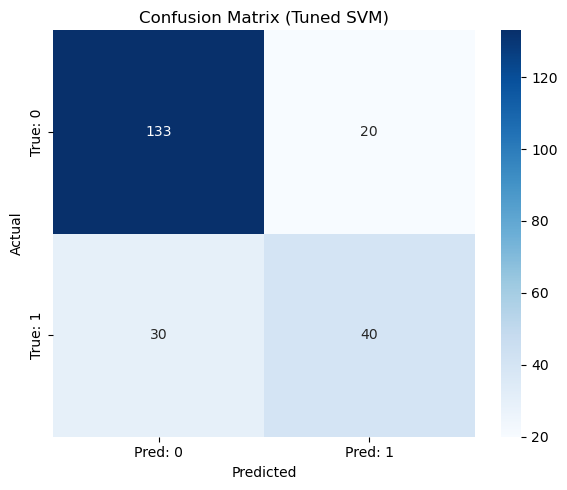

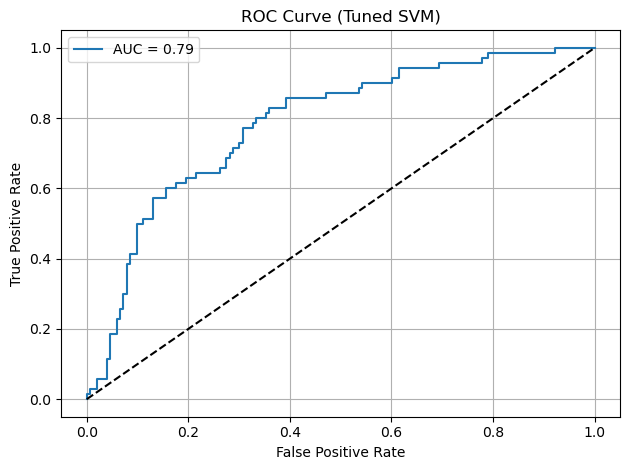

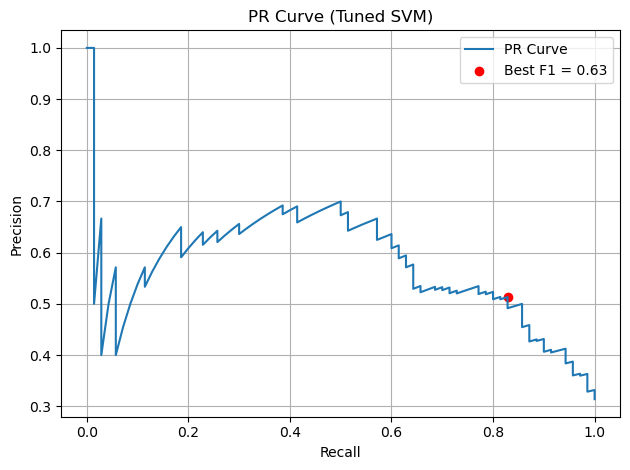

In [10]:
# 可视化结果
## 1. 混淆矩阵
cm = confusion_matrix(y_test, y_pred_custom)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: 0', 'Pred: 1'],
            yticklabels=['True: 0', 'True: 1'])
plt.title("Confusion Matrix (Tuned SVM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("confusion_matrix_svm.png", dpi=300)
plt.show()

## 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, probs)
auc_score = roc_auc_score(y_test, probs)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Tuned SVM)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("roc_curve_svm.png", dpi=300)
plt.show()

## 3. PR Curve
plt.figure()
plt.plot(recall, precision, label="PR Curve")
plt.scatter(recall[best_idx], precision[best_idx], color='red',
            label=f"Best F1 = {f1_scores[best_idx]:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve (Tuned SVM)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("pr_curve_svm.png", dpi=300)
plt.show()
